### Packages Required

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,precision_score,precision_recall_curve,roc_curve,auc,recall_score,accuracy_score,precision_recall_fscore_support

import tensorflow as tf
from pylab import rcParams
from keras.models import Model,load_model
from keras.layers import Dense,Input
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers

rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

### Datasets

In [3]:
path = 'C:/Users/Nithin/Downloads/Anomaly Detection_AI_Auto Encoders/'
df = pd.read_csv(path + 'Datasets/creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Exploratory Data Analysis

In [12]:
#check for any  nullvalues 
print("Any nulls in the dataset ",df.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(df['Class'].unique()))
print("Label values ",df.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(df['Class'], sort = True) )

Any nulls in the dataset  False
-------
No. of unique labels  2
Label values  [0 1]
-------
Break down of the Normal and Fraud Transactions
0    284315
1       492
Name: Class, dtype: int64


In [13]:
RANDOM_SEED = 314 #used to help randomly select the data points
TEST_PCT = 0.2 # 20% of the data
LABELS = ["Normal","Fraud"]

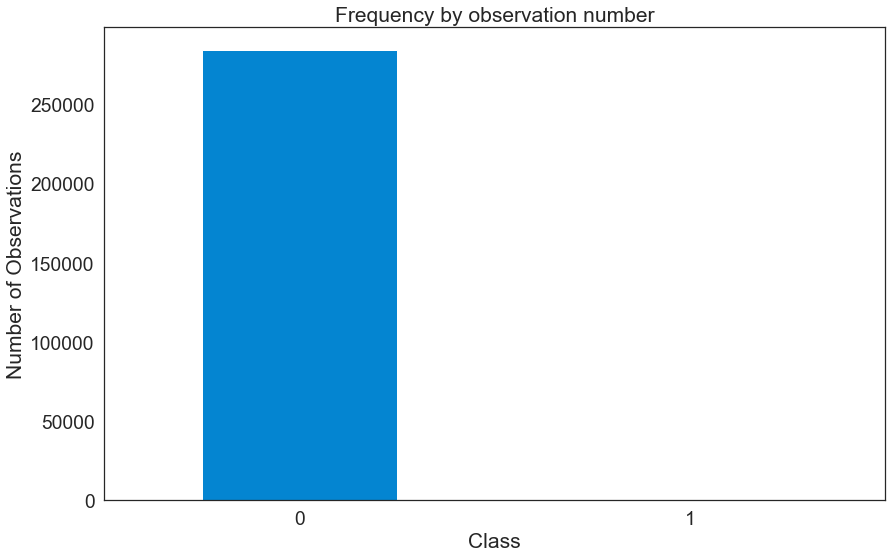

In [15]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(df['Class'].unique())), df.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [16]:
normal_df = df[df.Class == 0] 
fraud_df = df[df.Class == 1]

In [17]:
normal_df.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [18]:
fraud_df.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

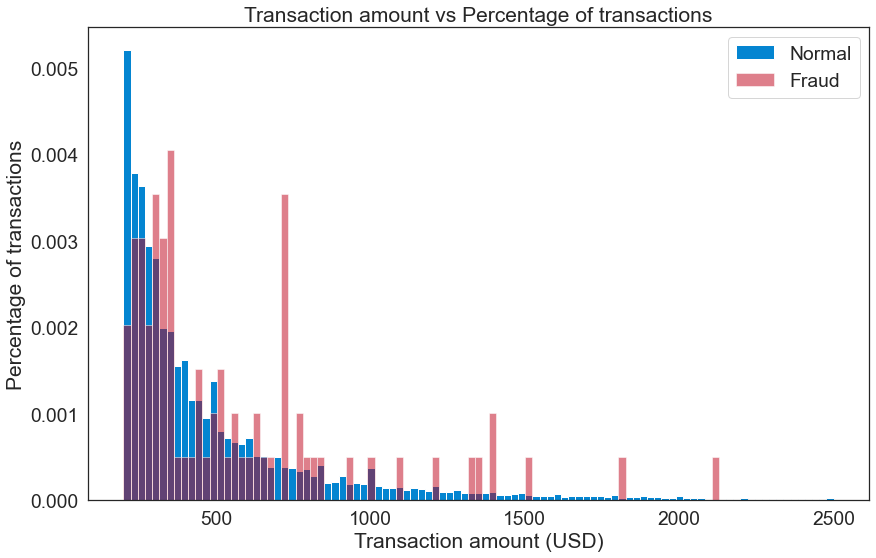

In [19]:
bins = np.linspace(200, 2500, 100)
plt.hist(normal_df.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_df.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions");
plt.show()

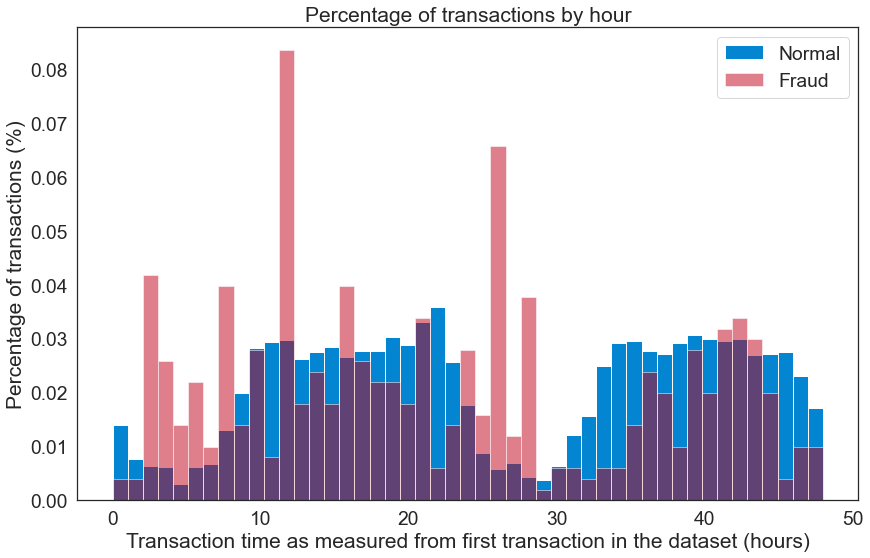

In [20]:
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((normal_df.Time/(60*60)), bins=bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
plt.show()

In [29]:
df_norm = df

sc=StandardScaler()
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

In [31]:
train_x, test_x = train_test_split(df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
train_x = train_x[train_x.Class == 0] #where normal transactions
train_x = train_x.drop(['Class'], axis=1) #drop the class column


test_y = test_x['Class'] #save the class column for the test set
test_x = test_x.drop(['Class'], axis=1) #drop the class column

train_x = train_x.values #transform to ndarray
test_x = test_x.values

### Model Building

In [32]:
nb_epoch = 100
batch_size = 128
input_dim = train_x.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

In [33]:
#input Layer
input_layer = Input(shape=(input_dim, ))

#Encoder
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)

# Decoder
decoder = Dense(encoding_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

#Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 14)                112       
                                                                 
 dense_3 (Dense)             (None, 30)                450       
                                                                 
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [35]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [36]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath= path + "Model/autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.000001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)

In [37]:
history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1,
                    callbacks=[cp, early_stop]).history

Epoch 1/100
1765/1778 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.5222
Epoch 1: val_loss improved from inf to 0.79854, saving model to C:/Users/Nithin/Downloads/Anomaly Detection_AI_Auto Encoders/Model\autoencoder_fraud.h5
1778/1778 [==============================] - 4s 2ms/step - loss: 0.8355 - accuracy: 0.5229 - val_loss: 0.7985 - val_accuracy: 0.6283
Epoch 2/100
1766/1778 [============================>.] - ETA: 0s - loss: 0.7519 - accuracy: 0.6424
Epoch 2: val_loss improved from 0.79854 to 0.77428, saving model to C:/Users/Nithin/Downloads/Anomaly Detection_AI_Auto Encoders/Model\autoencoder_fraud.h5
1778/1778 [==============================] - 3s 2ms/step - loss: 0.7515 - accuracy: 0.6422 - val_loss: 0.7743 - val_accuracy: 0.6495
Epoch 3/100
1772/1778 [============================>.] - ETA: 0s - loss: 0.7309 - accuracy: 0.6647
Epoch 3: val_loss improved from 0.77428 to 0.75662, saving model to C:/Users/Nithin/Downloads/Anomaly Detection_AI_Auto Encoders/

In [38]:
autoencoder = load_model(path + "Model/autoencoder_fraud.h5")

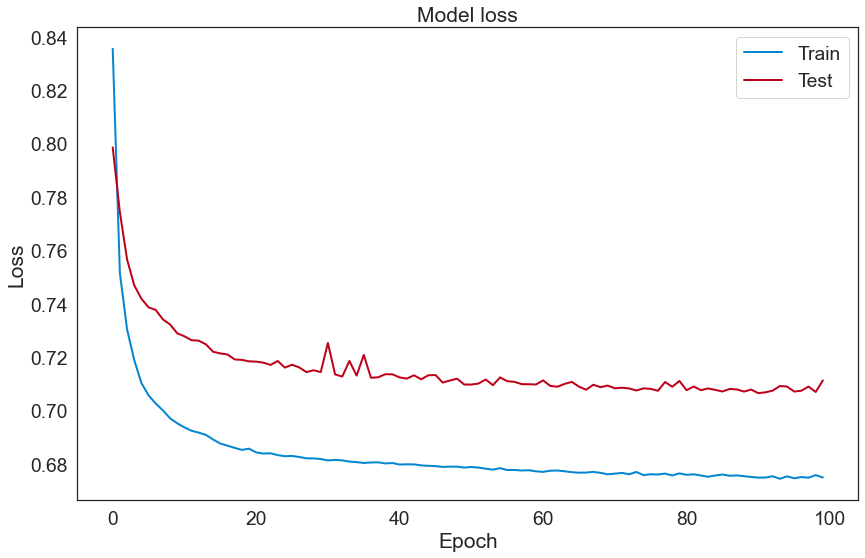

In [39]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [40]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

1781/1781 [==============================] - 4s 1ms/step


,Reconstruction_error,True_class
count,56962.000000,56962.000000
mean,0.706520,0.002019
std,3.041192,0.044887
min,0.042871,0.000000
25%,0.240573,0.000000
50%,0.376327,0.000000
75%,0.600181,0.000000
max,185.863994,1.000000


In [41]:
error_df

,Reconstruction_error,True_class
17645,0.203569,0
162875,0.428747,0
194000,0.179179,0
68589,0.121636,0
262202,0.129564,0
...,...,...
22627,0.337849,0
116708,1.325088,0
252381,0.273198,0
57362,0.215299,0


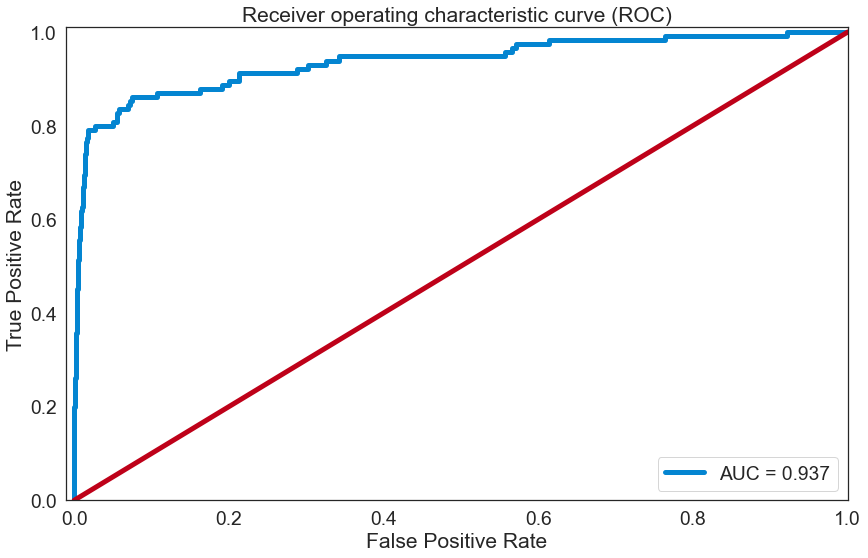

In [46]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

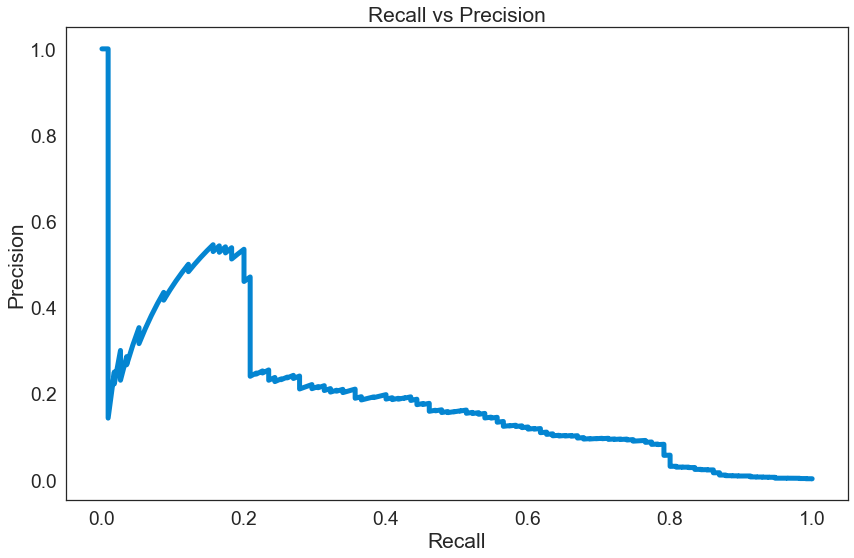

In [49]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

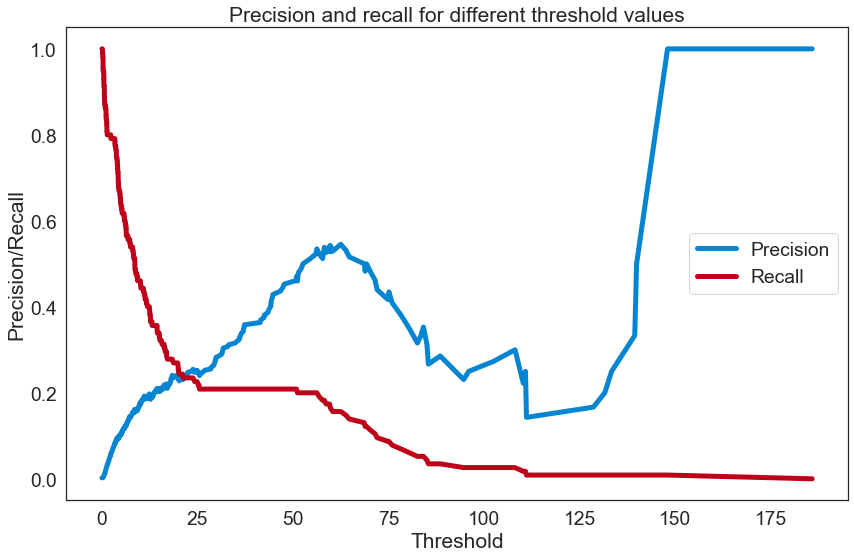

In [50]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [51]:
error_df.sort_values(by='Reconstruction_error', ascending=False, inplace=True)

In [52]:
error_df.sort_values(by='True_class', ascending=False, inplace=True)

In [53]:
error_df.head(10)

,Reconstruction_error,True_class
154371,185.863994,1
42009,12.749250,1
83053,4.285529,1
10497,0.672302,1
18472,4.302299,1
96341,0.234022,1
263274,14.527832,1
262826,14.472171,1
27627,4.342651,1
44556,13.161036,1


In [54]:
error_df.groupby('True_class').aggregate(np.mean)

,Reconstruction_error
True_class,
0,0.662392
1,22.520081


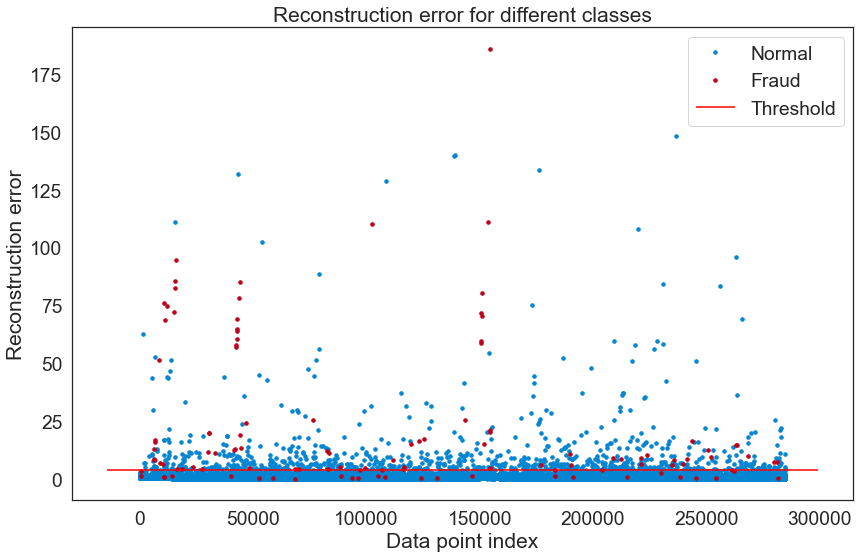

In [55]:
#Plotting the test data points and their respective reconstruction error sets a threshold value to visualize if the threshold value needs to be adjusted.
threshold_fixed = 4
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

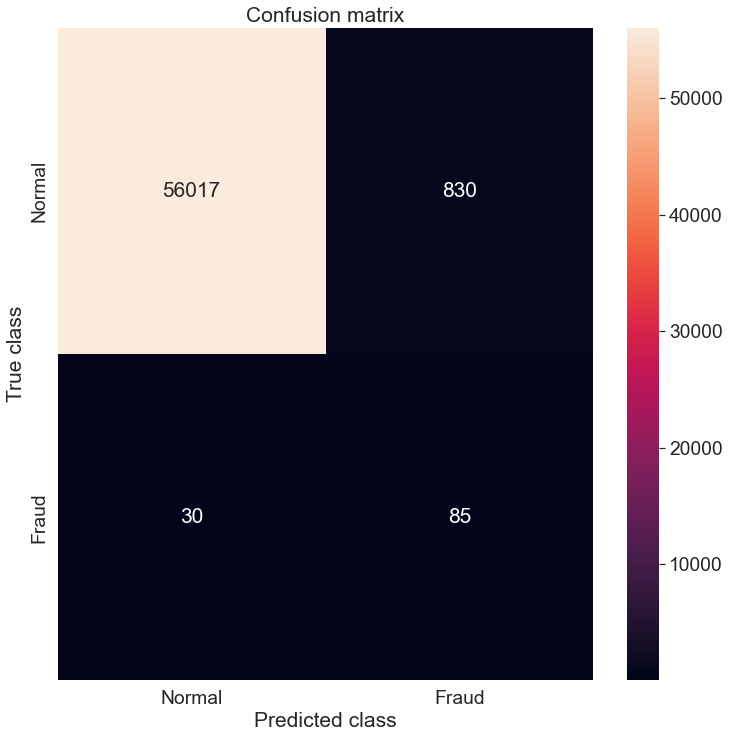

 Accuracy:  0.9849022155120958
 Recall:  0.7391304347826086
 Precision:  0.09289617486338798


In [58]:
threshold_fixed =4
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
error_df['pred'] =pred_y

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))